In [57]:
from IPython.display import display, Markdown, Latex
import pandas as pd
import numpy as np
import numpy.linalg
import scipy.stats as sps

import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.markers
from mpl_toolkits.mplot3d import Axes3D

from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from itertools import combinations,batched


RED = (0.2, 0, 0, 0.2)
GREEN = (0, 0.2, 0, 0.2)
BLUE = (0, 0, 0.2, 0.2)
NOCOL = (0, 0, 0, 0)

FIGSIZE = (8.5, 3)
MARGINS = {
    "left": 0.1,
    "bottom": 0.15,
    "right": 0.999,
    "top": 0.999
}
CMAP = 'gist_ncar'


def make_ax(fig, is3d):
    return fig.add_subplot(111, projection="3d") if is3d else fig.add_subplot(111)


def setup_ax(ax, **kwargs):
    ax.patch.set_facecolor(NOCOL)

    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    if ax.name == "3d":
        ax.set_zlabel(r"$z$")

    if "xlim" in kwargs:
        ax.set_xlim(kwargs["xlim"])
    if "ylim" in kwargs:
        ax.set_ylim(kwargs["ylim"])
    if "zlim" in kwargs:
        ax.set_zlim(kwargs["zlim"])


def make_fig(**kwargs):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(**MARGINS)
    fig.patch.set_facecolor(NOCOL)
    return fig


def fig_ax_template(**kwargs):
    fig = make_fig(**kwargs)

    ax = make_ax(
        fig, is3d="projection" in kwargs and kwargs["projection"] == "3d")
    setup_ax(ax, **kwargs)

    return fig, ax

In [58]:
NUM_ACTIVES = 3
STATES = {
    "хорошее(подъем)": 1,
    "среднее(равновесие)": 2,
    "плохое(спад)": 3
}

columns = [
    r"вероятность. $p(s)$",
    r"доходность 1, $\rho_1$",
    r"доходность 2, $\rho_2$",
    r"доходность 3, $\rho_3$"
]
data = [[0.3, 0.6, 0.1],
        [20, 20, 5],
        [30, 5, -20],
        [-10, 15, 15]]

PD_df = pd.DataFrame(dict(zip(columns, data)), index=STATES.keys())
display(Markdown(PD_df.to_markdown()))

|                     |   вероятность. $p(s)$ |   доходность 1, $\rho_1$ |   доходность 2, $\rho_2$ |   доходность 3, $\rho_3$ |
|:--------------------|----------------------:|-------------------------:|-------------------------:|-------------------------:|
| хорошее(подъем)     |                   0.3 |                       20 |                       30 |                      -10 |
| среднее(равновесие) |                   0.6 |                       20 |                        5 |                       15 |
| плохое(спад)        |                   0.1 |                        5 |                      -20 |                       15 |

In [59]:
def get_prob_index(df, prob_col=1, cols=[]):
    indexes_col = []
    values_col = []
    for col in cols:
        sizes = PD_df[col].value_counts(
            ascending=False).values

        indexes = PD_df[col].sort_values(
            ascending=False).index

        prob_indexes = []
        n1, n2 = 0, 0
        for size in sizes:
            n2 += size
            prob_indexes.append(indexes[n1:n2])
            n1 = n2
        indexes_col.append([df.loc[id][prob_col].sum() for id in prob_indexes])
        values_col.append([df.loc[id][col].values[0] for id in prob_indexes])
    return indexes_col, values_col


def get_distr(c):
    return sps.rv_discrete(values=(c.iloc[1], c.iloc[0]))


def get_exppayoff(c):
    return c.iloc[2].mean()


def get_var(c):
    return c.iloc[2].var()


def get_choice(m, sigma):
    if m[0] > m[1]:
        if sigma[0] < sigma[1]:
            return 0
        elif sigma[0] == sigma[1]:
            return 0
        else:
            return -1
    elif m[0] == m[1]:
        if sigma[0] < sigma[1]:
            return 0
        elif sigma[0] == sigma[1]:
            return 0
        else:
            return 1
    elif m[0] < m[1]:
        if sigma[0] < sigma[1]:
            return -1
        elif sigma[0] == sigma[1]:
            return 1
        else:
            return 1

In [60]:
probs, vals = get_prob_index(PD_df, PD_df.columns[0],  PD_df.columns[1:])
prob_df = pd.DataFrame([probs, vals], index=[
                       r"$\mathcal P$", "values"], columns=columns[1:])
display(Markdown(prob_df.to_markdown()))


prob_df.loc[r"distribution"] = prob_df.apply(get_distr)
prob_df.loc[r"$\mathbb E$"] = prob_df.apply(get_exppayoff)
prob_df.loc[r"$\mathbb D$"] = prob_df.apply(get_var)
display(Markdown(prob_df.to_markdown()))


sigma = list(combinations(prob_df.iloc[4], 2))
m = list(combinations(prob_df.iloc[3], 2))
cols = list(combinations(prob_df.columns, 2))
for i in range(len(cols)):
    if (n := get_choice(m[i], sigma[i]) == -1):
        display(Markdown(f"{cols[i][0]},"+f" {cols[i][1]} " + "не сравнимы "))

    else:
        display(
            Markdown(f"{cols[i][n]} более предпочтительна чем {cols[i][1-n]} "))

|              | доходность 1, $\rho_1$    | доходность 2, $\rho_2$   | доходность 3, $\rho_3$   |
|:-------------|:--------------------------|:-------------------------|:-------------------------|
| $\mathcal P$ | [0.8999999999999999, 0.1] | [0.3, 0.6, 0.1]          | [0.7, 0.3]               |
| values       | [20, 5]                   | [30, 5, -20]             | [15, -10]                |

|              | доходность 1, $\rho_1$                                                     | доходность 2, $\rho_2$                                                     | доходность 3, $\rho_3$                                                     |
|:-------------|:---------------------------------------------------------------------------|:---------------------------------------------------------------------------|:---------------------------------------------------------------------------|
| $\mathcal P$ | [0.8999999999999999, 0.1]                                                  | [0.3, 0.6, 0.1]                                                            | [0.7, 0.3]                                                                 |
| values       | [20, 5]                                                                    | [30, 5, -20]                                                               | [15, -10]                                                                  |
| distribution | <scipy.stats._distn_infrastructure.rv_sample object at 0x00000198C147EA80> | <scipy.stats._distn_infrastructure.rv_sample object at 0x00000198C2EF0B90> | <scipy.stats._distn_infrastructure.rv_sample object at 0x00000198C12090A0> |
| $\mathbb E$  | 18.5                                                                       | 10.0                                                                       | 7.5                                                                        |
| $\mathbb D$  | 20.249999999999943                                                         | 225.0                                                                      | 131.25                                                                     |

доходность 1, $\rho_1$ более предпочтительна чем доходность 2, $\rho_2$ 

доходность 1, $\rho_1$ более предпочтительна чем доходность 3, $\rho_3$ 

доходность 2, $\rho_2$, доходность 3, $\rho_3$ не сравнимы 

---------------------------------

**ПРИМЕР 3.1**

In [61]:

def check_partition(y):
    if not isinstance(y, (np.ndarray, np.generic)):
        raise (TypeError)
    if sum(y) < 0.99999:
        raise ("Asset portfolio must be normalized")
    return y


def asset_portfolio(y: np.array, *, rho: np.array, m: np.array, cov: np.array) -> None:
    r"""
    Портфель активов - вектор распределения долей капитала (y1,y2,...,yn), 
    ∑yk = 1

    yi = Wi°/W°, W° - общий капитал, Wi° - стоимость чатси  i портфеля

    Нужно рассчитать доходность портфеля, одижаемаю доходность портфеля, риск.

    Parameters
    ----------
    rho : np.array
        вектор доходностей
    m : np.array
        мат. ожидание вектора доходностей
    cov : np.array
        матрица ковариации доходностей
    """
    check_partition(y)
    rho_y = float(rho@y.T) if isinstance(rho,
                                         (np.ndarray, np.generic)) else None
    Ey = float(m@y.T) if isinstance(m,    (np.ndarray, np.generic)) else None
    Dy = float(y@cov@y.T) if isinstance(cov,
                                        (np.ndarray, np.generic)) else None
    return rho_y, Ey, Dy


def asset_portfolio_short_stack(W0, Wb, *, y: np.array, rho: np.array, m: np.array, cov: np.array):
    return asset_portfolio(np.append(y, -Wb/W0), rho=rho, m=m, cov=cov)


-----------------------------

**ПРИМЕР 3.2**

Изменения курсов двух акций энергетической $\Delta_\textit{Э}$ и нефтяной компании $\Delta_\textit{Н},$ пропорциональны изменению цены на нефть $\Delta$ с различными коэф-ми.

$\Delta_\textit{Э} = 0.8 \cdot \Delta, \;\; \Delta_\textit{Н} = 0.2 \cdot \Delta.$

Определены начальные стоимости активов $W^0_\textit{Н}, \;\; W^0_\textit{Н} \Rightarrow $ определим доходности 
$$
\rho_\textit{Н} = \frac{\Delta_\textit{Н}}{W^0_\textit{Н}},\;\;
\rho_\textit{Э} = \frac{\Delta_\textit{Э}}{W^0_\textit{Э}}
$$

$$
\frac{\rho_\textit{Э}}{\rho_\textit{Н}} = \frac{\Delta_\textit{Э}W^0_\textit{Н}}{\Delta_\textit{Н}W^0_\textit{Э}} = 4 \frac{W^0_\textit{Н}}{W^0_\textit{Э}} = a\;\; \Rightarrow \rho_\textit{Э} = a \cdot\rho_\textit{Н}
$$

$$
Cov = 
\left(
\begin{smallmatrix}
a^2 & a\\
a & 1
\end{smallmatrix}
\right) \mathbb D_\textit{Н}
$$

c:\Users\Stationary_PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


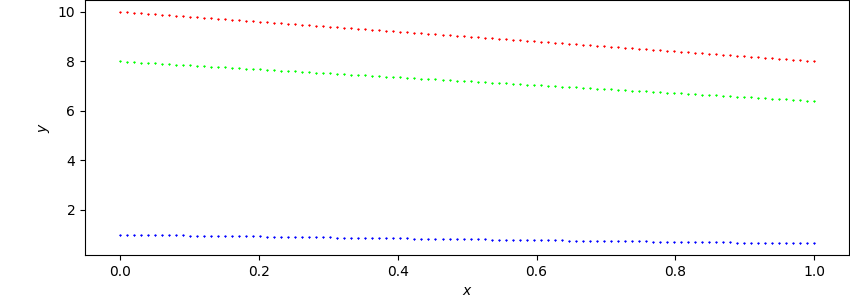

In [62]:

a = 0.8
h = np.array([a, 1])
rho = h*10
m = h*8
cov = np.array([[a*a, a], [a, 1]])

d = np.linspace(0, 1, 100)
ys = np.zeros(shape=(100, 2))
ys[:, 1] = d
ys[:, 0] = 1-d


fig, ax = fig_ax_template()

for y in ys:
    rho_y, Ey, Dy = asset_portfolio(
        y,
        rho=rho,
        m=m,
        cov=cov
    )
    ax.plot(y[0], rho_y, "*-", color=(1, 0, 0), linewidth=1, markersize=1)
    ax.plot(y[0], Ey,   "*-", color=(0, 1, 0), linewidth=1, markersize=1)
    ax.plot(y[0], Dy,   "*-", color=(0, 0, 1), linewidth=1, markersize=1)


-----------------------

# МОДЕЛЬ МАРКОВИЦА



In [63]:

def ellipse(a=1, b=1, size=1):
    X = np.zeros(shape=(size, 2))
    theta = np.linspace(0, 2*np.pi, size)
    X[:, 0] = a*np.cos(theta)
    X[:, 1] = b*np.sin(theta)
    return X


def hyperbola(a=1, b=1, size=1):
    X = np.zeros(shape=(size, 2))
    Y = np.zeros(shape=(size, 2))
    theta = np.linspace(-2, 2, size)
    X[:, 0] = a*np.cosh(theta)
    X[:, 1] = b*np.sinh(theta)

    Y[:, 0] = -a*np.cosh(theta)
    Y[:, 1] = b*np.sinh(theta)

    return np.vstack((X, Y))


def intersect_lines(a=1, b=1, size=1):
    X = np.zeros(shape=(size, 2))
    Y = np.zeros(shape=(size, 2))
    theta = np.linspace(-1, 1, size)
    X[:, 0] = np.linspace(-1, 1, size)
    X[:, 1] = -a/b * X[:, 0]

    Y[:, 0] = np.linspace(-1, 1, size)
    Y[:, 1] = a/b * X[:, 0]

    return np.vstack((X, Y))


def trans_canonic_curve(A, B, C, D, E, F, size=100):
    """ 
    уравнение вида Ax^2+2Bxy+Cy^2+2Dx+2Ey+F=0
    """

    # определяем сдвиг (в случае det!=0)
    x0 = np.linalg.solve(
        a=np.array(np.array([[A, B], [B, C]])),
        b=np.array([-D, -E]).reshape((-1, 1))
    )
    D_ = (A*x0[0]*x0[0] + C*x0[1]*x0[1]) + (2*D*x0[0] + 2*E*x0[1]) + F
    # новое уравнение Au^2+2Buv+Cv^2+D_=0
    x0 = x0.T

    if B:
        # случаи B!=0 не рассматриваем (но вообще по ккоду выше написаны матрицы поворота)
        return None

    # нормируем уравнение Au^2+Cv^2+D_=0

    if not (A*C):
        return None  # случаи A*C==0 не рассматриваем

    if A*C > 0:
        if A*D_ < 0:
            # эллипс
            a, b = np.sqrt(-D_/A), np.sqrt(-D_/C)
            return ellipse(a, b, size) + x0
        elif A*D_ > 0:
            return np.array([0, 0]).reshape(-1, 1)  # точка
        elif not (D_):
            print("пара пересекающихся мнимых прямых")
            return np.array([])
    elif A*C < 0:
        if A*D_ < 0:
            # гипербола
            a, b = np.sqrt(-D_/A), np.sqrt(D_/C)
            return hyperbola(a, b, size) + x0
        elif A*D_ > 0:
            # гипербола
            a, b = np.sqrt(D_/A), np.sqrt(-D_/C)
            return hyperbola(a, b, size) + x0
        else:
            # |A|u^2-|C|v^2=0
            a, b = np.sqrt(np.abs(A)), np.sqrt(np.abs(C))
            return intersect_lines(a, b, size) + x0


def get_det(A, B, C):
    return np.linalg.det(np.array([[A, B], [B, C]]))


def get_det1(A, B, C, D, E, F):
    return np.linalg.det(np.array([[A, B, D], [B, C, E], [D, E, F]]))


def dkm_boundaty(E, D):
    """  
    x.shape==(-1, 3)
    batch_size = 10
    для меры риска будем использоавть взвешеннуб смесь матожидания и дисперсии pi = D - beta*E
    """
    BETA = 0.9
    BATCH_SIZE = 20
    sol = []

    id_batches = batched(E.argsort(), BATCH_SIZE)
    for batch in id_batches:
        b = np.array(batch)
        Q = np.stack((D[b], E[b]), axis=1)
        sol.append(min(Q, key=lambda q: q[0] - BETA*q[1]))

    return np.array(sol).T


def dkm_boundaty_smooth(x, m, cov, EPSILON = 0.1):
    """  
    x.shape==(-1, 3)
    batch_size = 10
    для меры риска будем использоавть взвешеннуб смесь матожидания и дисперсии pi = D - beta*E
    """
    BETA = 0.9
    sol = []
    sol_im= []
    count = 1
    for i in np.arange(0.0, 1, EPSILON):
        
        id = (x[:, 0] > i) & (x[:, 0] < i + EPSILON)
        order = np.arange(0, 1, EPSILON) if count%2  else np.arange(1-EPSILON, 0+EPSILON, -EPSILON)
        count+=1
        countj = 1
        for j in  order:
            jd = (x[id][:,1] > j) & (x[id][:,1] < j + EPSILON)
            
            if x.shape[1]==2:
                batch = x[id][jd]
                E = batch@m
                D = np.sqrt([x_@cov@x_.T for x_ in batch])
                Q = np.stack((D, E), axis=1)
                if len(Q): 
                    s = min(Q, key=lambda q: q[0] - BETA*q[1])
                    sol.append(s)
                    sol_im.append(batch[Q == s])
            else:
                orderj = np.arange(0, 1, EPSILON) if count%2  else np.arange(1-EPSILON, 0+EPSILON, -EPSILON)
                countj += 1
                for k in  orderj:
                    kd = (x[id][jd][:,2] > k) &( x[id][jd][:,2] < k + EPSILON)
                    batch = x[id][jd][kd]

                    E = batch@m
                    D = np.sqrt([x_@cov@x_.T for x_ in batch])
                    Q = np.stack((D, E), axis=1)
                    norm = 0 if not(sol) else np.linalg.norm(Q-sol[-1]) 
                    if len(Q):
                        s = min(Q, key=lambda q: q[0] - BETA*q[1])
                        sol.append(s)
                        sol_im.append(batch[(Q == s)[:,0]])
    #D,E  = np.array(sol).T
    return np.array(sol).T, np.array(sol_im)


def dkm(m: np.array, cov: np.array, fig, ax):
    sigma = np.sqrt(cov.diagonal())
    r12 = cov[0, 1]/np.prod(sigma)

    if -1 < r12 and r12 < 1:
        print("рисуем гиперболу по коэффициентам")
    elif r12 == 1:
        if sigma[0] == sigma[1]:
            print("прямая")
        else:
            print("две прямых (пересекающихся)")
    elif r12 == -1:
        print("две прямых (пересекающихся)")

    A = -pow(m[0]-m[1], 2)
    B = 0
    C = pow(sigma[0]-sigma[1], 2) + 2*(1-r12)*sigma[0]*sigma[1]
    D = 0
    E = (m[0]+m[1])*r12*sigma[0]*sigma[1]-m[1] * \
        pow(sigma[0], 2) - m[0]*pow(sigma[1], 2)
    F = pow(m[1]*sigma[0], 2) + pow(m[0]*sigma[1], 2) - \
        2*m[0]*m[1]*r12*sigma[0]*sigma[1]

    det = get_det(A, B, C)
    det1 = get_det1(A, B, C, D, E, F)
    if not (det):
        return

    # РИСУНОК
    x = trans_canonic_curve(A, B, C, D, E, F, size=10000)
    if not (x.size):
        return
    x = x[x[:, 1] < max(m)]
    x = x[x[:, 1] > min(m)]
    x = x[x[:, 0] < max(sigma)**2]
    x = x[x[:, 0] > 0]

    ax.plot(x[:, 0], x[:, 1])

In [64]:
a = np.array([[1,2,3,2.4],[1,2,3,2.4]])


In [65]:
# Можно конечно прозе все решить...
# from sympy import plot_implicit, Eq
# from sympy.abc import x, y
# a = -1
# b = 3
# plot_implicit(Eq((y - a * x) * (y - b * x), -1), (x, -10, 10), (y, -10, 10))
# ЕЩЕ ПРОЩЕ (не нашел сразу)
# https://mmas.github.io/conics-matplotlib

In [66]:
# ROTATION
# theta_x = np.radians(45)
# rot_matrix_x = np.array([
#     [1, 0,                              0],
#     [0, np.cos(theta_x), -np.sin(theta_x)],
#     [0, np.sin(theta_x), np.cos(theta_x)]
# ])
# theta_y = np.radians(45)
# rot_matrix_y = np.array([
#     [np.cos(theta_x), 0,  np.sin(theta_x)],
#     [0,              1,                 0],
#     [-np.sin(theta_x), 0,    np.cos(theta_x)]
# ])
# theta_z = np.radians(-45)
# rot_matrix_z = np.array([
#     [np.cos(theta_x), -np.sin(theta_x), 0],
#     [np.sin(theta_x), np.cos(theta_x), 0],
#     [0,            0,                  1]
# ])
# https://math.stackexchange.com/questions/351472/3d-matrix-rotation

C:\Users\Stationary_PC\AppData\Local\Temp\ipykernel_13812\1553882830.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=FIGSIZE)


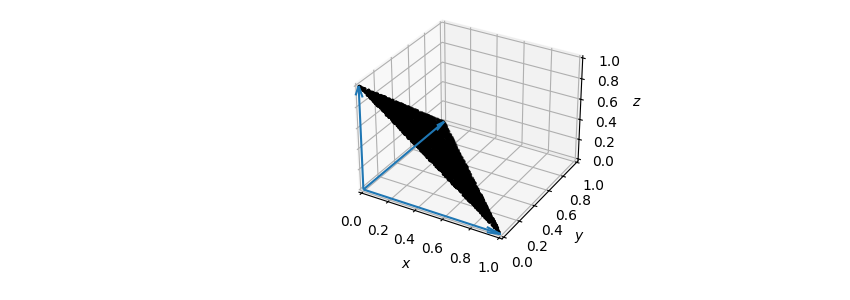

In [67]:
%matplotlib widget

SIZE = 10000
X = np.zeros(shape=(SIZE, 3))
X[:, 0] = npr.uniform(0, 1, SIZE)
X[:, 1] = npr.uniform(0, 1, SIZE)
X[:, 2] = 1 - X[:, 0] - X[:, 1]
X = X[X[:, 2] > 0]  # если выбираем модель марковица
# X = rot_matrix_x@rot_matrix_y@rot_matrix_z@X


fig, ax = fig_ax_template(projection="3d", xlim=(0, 1),
                          ylim=(0, 1), zlim=(0, 1))
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=(0, 0, 0, 1), s=2)

# draw axis
x, y, z = np.zeros((3, 3))
u, v, w = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.1)


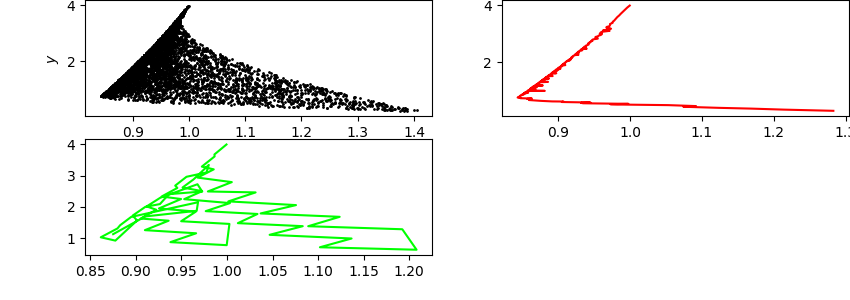

In [68]:
m = np.array([1, 0.2, 4])
cov = np.array([[1, 0.1, 0.9], [0.1, 2, 0.8], [0.9, 0.8, 1]])
E = X@m
D = np.sqrt([x@cov@x.T for x in X])
fig, ax = fig_ax_template()
ax.scatter(D, E, s=1, color=(0, 0, 0))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "100%", pad="20%")
D,E = dkm_boundaty(E,D)
cax.plot(D,E, color = (1,0,0), markersize = 1)

cax1 = divider.append_axes("bottom", "100%", pad="20%")
(D,E),x = dkm_boundaty_smooth(X,m,cov, 0.1)
cax1.plot(D,E,  color = (0,1,0))

рисуем гиперболу по коэффициентам


Text(0.5, 0, '$\\lambda$')

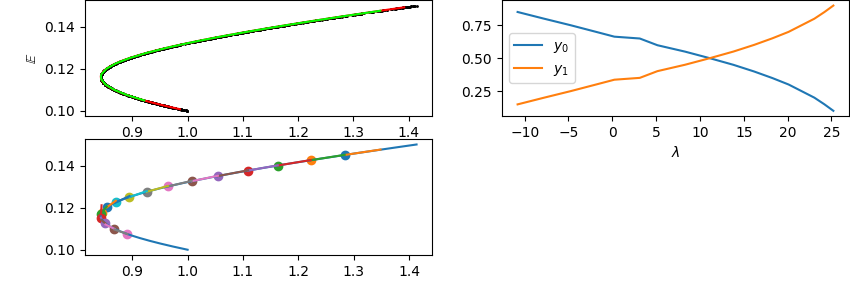

In [69]:
SIZE = 1000
X = np.zeros(shape=(SIZE, 2))
X[:, 0] = npr.uniform(0, 1, SIZE)
X[:, 1] = 1 - X[:, 0]

m = np.array([0.1, 0.15])
cov = np.array([[1, 0.1], [0.1, 2]])
E = X@m
D = np.sqrt([x@cov@x.T for x in X])

fig, ax = fig_ax_template()
ax.set_ylabel(r"$\mathbb{E}$")
ax.set_xlabel(r"$\sigma$")

ax.scatter(D, E, s=1, color=(0, 0, 0))

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", "100%", pad="20%")
dkm(m, cov, fig, cax)


D1,E1 = dkm_boundaty(E,D)
ax.plot(D1,E1,  color = (1,0,0), markersize = 1)






(D,E),x = dkm_boundaty_smooth(X,m,cov,0.05)
ax.plot(D,E,  color = (0,1,0), markersize = 1)


#для меры риска будем использоавть взвешеннуб смесь матожидания и дисперсии pi = D - beta*E
id = np.arange(1,len(E)-1,1)
hn = 1
lamda =  (D[id+hn]-D[id-hn])/(E[id+hn]-E[id-hn])
l = iter(lamda)
for i in id:
    func = lambda sigma: E[i] + 1/next(l)*(sigma - D[i])
    cax.plot(D[i-hn:i+hn],func(D[i-hn:i+hn]))
    cax.scatter(D[i],E[i])



cax = divider.append_axes("right", "100%", pad="20%")
cax.plot(lamda, x[id,0],label = r"$y_0$")
cax.plot(lamda, x[id,1],label = r"$y_1$")
cax.legend()
cax.set_xlabel(r"$\lambda$")


две прямых (пересекающихся)


Text(0.5, 0, '$\\lambda$')

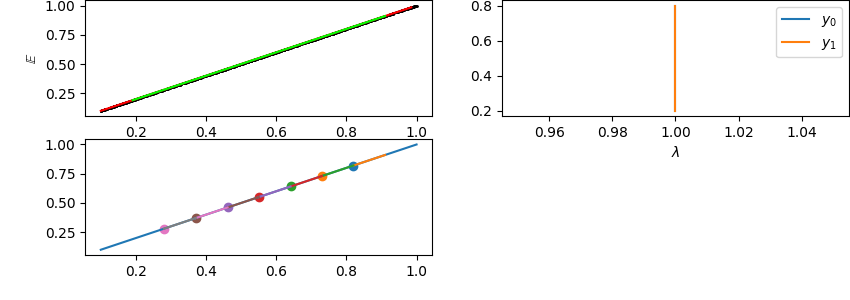

In [70]:
a = 0.1
h = np.array([a, 1])
m = h
cov = np.array([[a*a, a], [a, 1]])
E = X@m
D = np.sqrt([x@cov@x.T for x in X])

fig, ax = fig_ax_template()
ax.set_ylabel(r"$\mathbb{E}$")
ax.set_xlabel(r"$\sigma$")
ax.scatter(D, E, s=1, color=(0, 0, 0))

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", "100%", pad="20%")
dkm(m, cov, fig, cax)
D,E = dkm_boundaty(E,D)
ax.plot(D,E,  color = (1,0,0), markersize = 1)


(D,E),x = dkm_boundaty_smooth(X,m,cov)
ax.plot(D,E,  color = (0,1,0), markersize = 1)


#для меры риска будем использоавть взвешеннуб смесь матожидания и дисперсии pi = D - beta*E
id = np.arange(1,len(E)-1,1)
hn = 1
lamda =  (D[id+hn]-D[id-hn])/(E[id+hn]-E[id-hn])
l = iter(lamda)
for i in id:
    func = lambda sigma: E[i] + 1/next(l)*(sigma - D[i])
    cax.plot(D[i-hn:i+hn],func(D[i-hn:i+hn]))
    cax.scatter(D[i],E[i])



cax = divider.append_axes("right", "100%", pad="20%")
cax.plot(lamda, x[id,0],label = r"$y_0$")
cax.plot(lamda, x[id,1],label = r"$y_1$")
cax.legend()
cax.set_xlabel(r"$\lambda$")

# Модель Блэка


----------------

**Модель Блэка**


**НАЙТИ** распределение долей капитала в портфеле $\textbf y,$ с фиксированной ожидаемой доходностью $\textbf m$ :
$\textbf y^T\textbf m = m^*$



и **МИНИМИЗИРОВАТЬ** риск портфеля $\textbf y^T COV \textbf y \to \min\limits_{\textbf y}$ 


Модель Блэка задана $\sum\limits_{i=1}^n y_i = 1$, т.е. может описывать портфель  с учетом коротких позиций $\sum\limits_{i=1}^{n+1} y_i = 1, $ где $y_{n+1} = \frac{W^b}{W^0},$  $W^b$ - цена актива с короткой позиции (заемный капитал), $W^0$ - свой капитал



перепишем задачу в виде:
$\begin{equation}
\textbf y^T COV \textbf y \to \min\limits_{\textbf y},\end{equation}$
$\begin{equation}
\textbf y^T\textbf m = m^*,\end{equation}$
$\begin{equation}\mathbf I^T \textbf y = 1
\end{equation}$


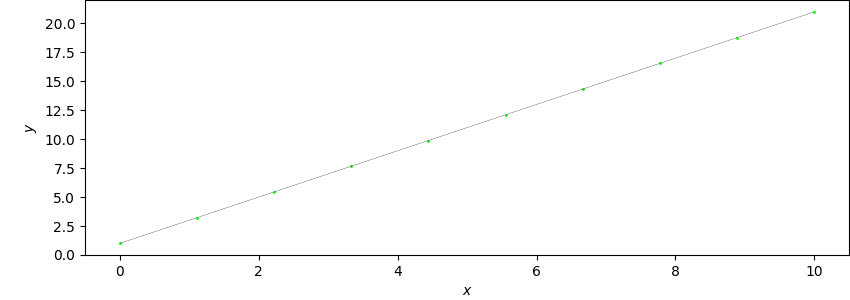

In [71]:
fig, ax = fig_ax_template()
N = 10
m = np.array([1, -1])
u = np.linspace(0, N, N)
ys = np.zeros(shape=(N, 2))
ys[:, 0] = 1+u
ys[:, 1] = -u
for y in ys:
    _, Ey, _ = asset_portfolio(y, m=m, cov=None, rho=None)
    ax.plot(-y[1], Ey,   "o", color=(0, 1, 0), markersize=1)

ax.plot(-ys[:, 1],  1 - 2*ys[:, 1], color=(0, 0, 0), linewidth=0.2)

In [72]:
def check_degenerate(m: np.ndarray):
    """ 
    проверка вырожденного случая
    m_1 = m_2 = ... m_n = = m*
    """
    return (m == m[0]).all()


def draw_risk_revenue_rel(cov_1, m_1, m_, I, A, B, C):
    k1 = (A*m_ - C*I)/(C*C-B*A)
    k2 = (B*I - m_*C)/(C*C-B*A)
    a = float(k1.T@cov_1@k1)
    b = float(k2.T@cov_1@k1)
    c = float(k2.T@cov_1@k2)

    parabola = np.vectorize(lambda x: a*pow(x, 2) + 2 * b * x + c)
    x = np.linspace(0, 0.2, 100)
    y = parabola(x)
    fig, ax = fig_ax_template()
    ax.set_xlabel(r"$\mathbb{E}$")
    ax.set_ylabel(r"$\sigma$")
    ax.plot(x, y, label="эффективная граница", color=(0, 0, 1))
    ax.vlines(-b/a, y.min(), y.max(),
              label="минимальный риск", color=(1, 0, 0))
    ax.legend()


def not_deg_sol(cov_1, m_1, m_, I, A, B, C):
    return -cov_1@(m_1*(A*m_ - C*I) + B*I - m_*C)/(C*C-B*A)


def deg_sol(cov_1, I, A):
    return cov_1@I/A


def disable_warnings(func):
    def inner(*args, **kwargs):
        warnings.simplefilter("ignore")
        res = func(*args, **kwargs)
        warnings.simplefilter("default")
        return res
    return inner


@disable_warnings
def solution(m: np.ndarray, cov: np.array, draw: bool = False):
    m_ = m.reshape(-1, 1)
    I = np.ones(shape=m_.shape)

    m_1 = float(I.T@m_)
    cov_1 = np.linalg.inv(cov)

    A = float(I.T@cov_1@I)
    B = float(m_.T@cov_1@m_)
    C = float(I.T@cov_1@m_)

    sol = deg_sol(cov_1, I, A) if check_degenerate(
        m) else not_deg_sol(cov_1, m_1, m_, I, A, B, C)

    if draw:
        draw_risk_revenue_rel(cov_1, m_1, m_, I, A, B, C)

    return sol

array([[-0.66666667],
       [ 1.66666667]])

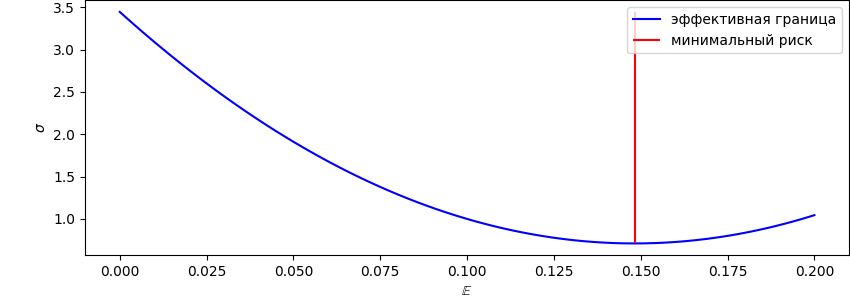

In [73]:
m = np.array([0.1, 0.25])
cov = np.array([[1, 0.1], [0.1, 2]])
solution(m, cov, True)

array([[ 4.60300043],
       [-3.76638328],
       [ 0.16338286]])

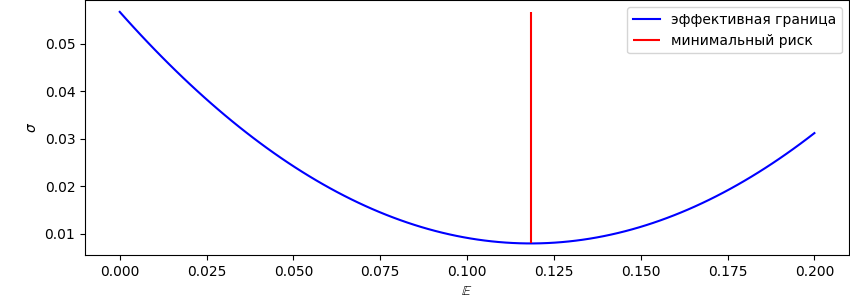

In [74]:
m = np.array([0.2553, 0.1675, 0.1452])
cov = np.array([
    [.08, 0.039, 0.008], [0.039, 0.025, -0.002], [0.008, -0.002, 0.035],
])
solution(m, cov, True)


---------

# Модель Тобина-Шарпа-Литнера

*особенность* наличие безрискового актива, доходность примет вид
$\rho = \mu\rho_F + (1-\mu)\rho_A$

$\mathbb E \rho = \mu\rho_F + (1-\mu)\mathbb E\rho_A$

$\mathbb D \rho =(1-\mu)^2\sigma^2_A$

$\mu$ - доля безрискового актива


-----

рассмотрим ситуацию без заема $0< \mu < 1$ 


c:\Users\Stationary_PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


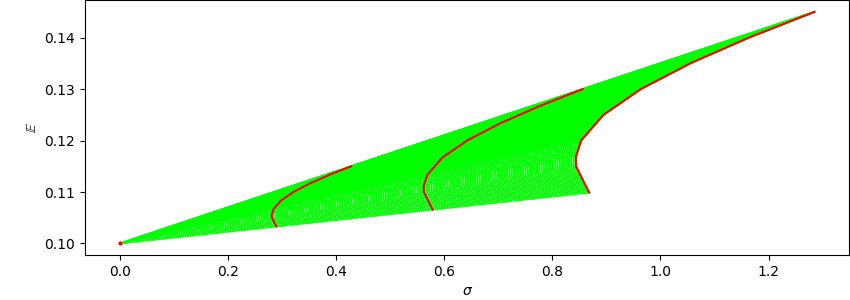

In [75]:
SIZE = 1000
X = np.zeros(shape=(SIZE, 2))
X[:, 0] = npr.uniform(0, 1, SIZE)
X[:, 1] = 1 - X[:, 0]

m = np.array([0.1, 0.15])
cov = np.array([[1, 0.1], [0.1, 2]])


#безрисковый актив
rhoF = 0.1


fig, ax = fig_ax_template()
ax.set_ylabel(r"$\mathbb{E}$")
ax.set_xlabel(r"$\sigma$")

(D,E),x = dkm_boundaty_smooth(X,m,cov)


for mu in np.linspace(0,1,200):
    D1 = (1-mu)*D
    E1 = mu*rhoF + (1-mu)*E
    ax.plot(D1,E1,  color = (0,1,0), markersize = 1)
    
for mu in np.linspace(0,1,4):
    D1 = (1-mu)*D
    E1 = mu*rhoF + (1-mu)*E
    ax.plot(D1,E1,  color = (1,0,0), markersize = 1)
ax.plot(0, rhoF, "o", color = (1,0,0), markersize = 2)



------

рассмотрим ситуацию когда инвестор может брать любой заем

$\mu = 1 - \frac{\sigma}{\sigma_A}$

$\mathbb E \rho = \rho_F + \frac{\mathbb E \rho_A - \rho_F}{\sigma_A} \sigma$

MARKET LINE

задается следующим уравнением

$
\mathbb E = \rho_F + \frac{\mathbb E_M - \rho_F}{\sigma_M}\sigma$

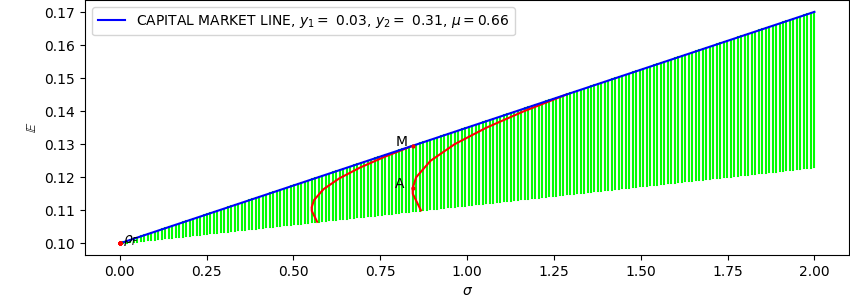

In [76]:
SIZE = 1000
X = np.zeros(shape=(SIZE, 2))
X[:, 0] = npr.uniform(0, 1, SIZE)
X[:, 1] = 1 - X[:, 0]

m = np.array([0.1, 0.15])
cov = np.array([[1, 0.1], [0.1, 2]])


#безрисковый актив
rhoF = 0.1


fig, ax = fig_ax_template()
ax.set_ylabel(r"$\mathbb{E}$")
ax.set_xlabel(r"$\sigma$")

(D,E),x = dkm_boundaty_smooth(X,m,cov)

E1 = lambda sigma: rhoF + (E - rhoF)/D * sigma

for sigma in np.linspace(0,2,200):
    D1 = np.ones_like(D)*sigma
    ax.plot(D1,E1(sigma),color = (0,1,0))

idA = D.argsort()[0]

EA,DA = E[idA],D[idA]
EM,DM = max(E1(DA)),D[idA]

ax.plot(D,E1(D),color = (1,0,0))

sigma01 = (EM-rhoF)/(E1(D)[0]-rhoF)
x1 = x[0]*(1-sigma01)
ax.plot(D*sigma01,E1(D*sigma01),color = (1,0,0))

E2 = lambda sigma: rhoF + (EM - rhoF)/DM*sigma
sigma1 = np.linspace(0,2,100)
ax.plot(sigma1,E2(sigma1),color = (0,0,1), label = r"CAPITAL MARKET LINE, $y_1 = $ "+ f"{x1[0]:.2f}, "r"$y_2 = $"+f" {x1[1]:.2f}, " + r"$\mu = $"+ f"{sigma01:.2f}")



ax.plot(DA,EA,"o",color = (1,0,0), markersize = 2)
ax.text(DA-0.05,EA, "A")
ax.text(0+0.01,rhoF, r"$\rho_F$")
ax.plot(np.zeros_like(D),E1(0),"o",color = (1,0,0),markersize=2)

ax.plot(DM,EM,"o",color = (1,0,0), markersize = 2)
ax.text(DM-0.05,EM, "M")

ax.set_title("MARKET LINE")

ax.legend()

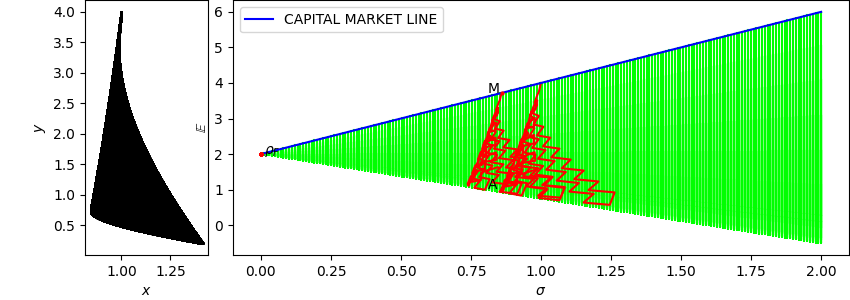

In [111]:
SIZE = 10000000
X = np.zeros(shape=(SIZE, 3))
X[:, 0] = npr.uniform(0, 1, SIZE)
X[:, 1] = npr.uniform(0, 1, SIZE)
X[:, 2] = 1 - X[:, 0] - X[:, 1]
X = X[X[:, 2] > 0]  # если выбираем модель марковица

m = np.array([1, 0.2, 4])
cov = np.array([[1, 0.1, 0.9], [0.1, 2, 0.8], [0.9, 0.8, 1]])
E = X@m
D = np.sqrt([x@cov@x.T for x in X])
fig, cax = fig_ax_template()
cax.scatter(D, E, s=1, color=(0, 0, 0))




divider = make_axes_locatable(cax)
ax = divider.append_axes("right", "500%", pad="20%")

#безрисковый актив
rhoF = 2


ax.set_ylabel(r"$\mathbb{E}$")
ax.set_xlabel(r"$\sigma$")

(D,E),x = dkm_boundaty_smooth(X,m,cov,0.081)

E1 = lambda sigma: rhoF + (E - rhoF)/D * sigma

for sigma in np.linspace(0,2,200):
    D1 = np.ones_like(D)*sigma
    ax.plot(D1,E1(sigma),color = (0,1,0))

idA = D.argsort()[0]

EA,DA = E[idA],D[idA]
EM,DM = max(E1(DA)),D[idA]

ax.plot(D,E1(D),color = (1,0,0))

sigma01 = (EM-rhoF)/(E1(D)[0]-rhoF)
x1 = x[0]*(1-sigma01)
ax.plot(D*sigma01,E1(D*sigma01),color = (1,0,0))

E2 = lambda sigma: rhoF + (EM - rhoF)/DM*sigma
sigma1 = np.linspace(0,2,100)
ax.plot(sigma1,E2(sigma1),color = (0,0,1), label = r"CAPITAL MARKET LINE")



ax.plot(DA,EA,"o",color = (1,0,0), markersize = 2)
ax.text(DA-0.05,EA, "A")
ax.text(0+0.01,rhoF, r"$\rho_F$")
ax.plot(np.zeros_like(D),E1(0),"o",color = (1,0,0),markersize=2)

ax.plot(DM,EM,"o",color = (1,0,0), markersize = 2)
ax.text(DM-0.05,EM, "M")

ax.set_title("MARKET LINE")

ax.legend()

In [108]:
sigma01

0.8595548044509741

In [109]:
y = x[0]*(1-sigma01)

In [110]:
y.sum() + sigma01

1.0